In [118]:
import os
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import wilcoxon

# Constants

In [119]:
lead_times = [0,1,2,3,4,5,6,7,8,9]
experiment_names = ["SIC_Attention_Res_UNet", "SIC_Attention_Res_UNet_without_TOPAZ", "SIC_Attention_Res_UNet_without_ECMWF", "SIC_Attention_Res_UNet_without_any_obs"]
#
date_min = "20220101"
date_max = "20221231"
period = date_min + "_" + date_max
#
path_output = "/lustre/storeB/users/cyrilp/COSI/Figures/Article/" 
if os.path.isdir(path_output) == False:
    os.system("mkdir -p " + path_output)
#
sizefont = 25
sizefont_legend = 14.6
linewidth = 3
alpha = 1

# Functions

In [120]:
def read_dataset(experiment_names, period, lead_times):    
    Scores = {}
    #
    for exp in experiment_names:
        for lt, leadtime in enumerate(lead_times):
            path_exp = "/lustre/storeB/project/copernicus/cosi/WP3/Data/Predictions/" + exp + "/lead_time_" + str(leadtime) + "_days/scores/"
            Dataset = pd.read_csv(path_exp + "Scores_" + period + ".txt", delimiter = "\t")
            #
            for var in Dataset:
                if lt == 0:
                    Scores[exp + "_" + var] = np.full(len(lead_times), np.nan)
                    Scores[exp + "_" + var][lt] = np.mean(Dataset[var])
                else:
                    Scores[exp + "_" + var][lt] = np.mean(Dataset[var])
    #
    return(Scores)

In [121]:
def calculate_wilcoxon(experiment_1, experiment_2, period, lead_times, metrics = ["RMSE", "IIEElength_15"]):
    Wilcoxon = {}
    Pvalue = {}
    for met in metrics:
        Wilcoxon[met] = np.full(len(lead_times), np.nan)
        Pvalue[met] = np.full(len(lead_times), np.nan)
    #
    experiments = [experiment_1, experiment_2]
    for lt, leadtime in enumerate(lead_times):
        Datasets = {}
        for exp in experiments:
            path_exp = "/lustre/storeB/project/copernicus/cosi/WP3/Data/Predictions/" + exp + "/lead_time_" + str(leadtime) + "_days/scores/"
            Datasets[exp] = pd.read_csv(path_exp + "Scores_" + period + ".txt", delimiter = "\t")
        #
        for met in metrics:
            Wilcoxon[met][lt], Pvalue[met][lt] = wilcoxon(Datasets[experiment_1][met + "_ML"], Datasets[experiment_2][met + "_ML"], zero_method = "wilcox", correction = False, alternative = "two-sided", mode = "auto")
    #
    return(Wilcoxon, Pvalue)

In [122]:
def make_figure_absolute_several_ice_edges(Scores, experiment_names, lead_times, sizefont, sizefont_legend, saving = False):
    #
    colorscale = plt.cm.tab20b
    colors = colorscale(np.linspace(0, 1, len(experiment_names) + 1))
    lead_times_fig = [str(x) for x in (np.array(lead_times) + 1)]
    #
    plt.figure()
    plt.rc("xtick", labelsize = sizefont)
    plt.rc("ytick", labelsize = sizefont)
    fig, ax = plt.subplots(1, 4, figsize = (40, 10), facecolor = "w", edgecolor = "k")
    #
    ax = plt.subplot(141)
    for v, var in enumerate(experiment_names):
        RMSE = Scores[var + "_RMSE_ML"]
        label_str = var.replace("SIC_Attention_Res_UNet", "Deep learning").replace("_T4", "_TOPAZ4").replace("_without_TOPAZ", " without sea ice forecasts").replace("_without_ECMWF", " without weather forecasts")
        l = ax.plot(lead_times_fig, RMSE, color = colors[v], label = label_str, linewidth = linewidth, alpha = alpha)
    ax.grid()
    ax.set_title("RMSE", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("RMSE (%)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    ax.legend(fontsize = sizefont_legend, loc = 'best', ncol = 1)
    #ax.set_ylim([])
    #
    ax = plt.subplot(142)
    for v, var in enumerate(experiment_names):
        IIEElength = 0.001 * (np.array(Scores[var + "_IIEElength_10_ML"]))
        l = ax.plot(lead_times_fig, IIEElength , color = colors[v], label = var.replace("_T4", "_TOPAZ4"), linewidth = linewidth, alpha = alpha)
    ax.grid()
    ax.set_title("Ice edge distance error (10 % SIC)", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("Distance error (km)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    #ax.legend(fontsize = sizefont_legend, loc = 'best', ncol = 1)
    #
    ax = plt.subplot(143)
    for v, var in enumerate(experiment_names):
        IIEElength = 0.001 * (np.array(Scores[var + "_IIEElength_15_ML"]))
        l = ax.plot(lead_times_fig, IIEElength , color = colors[v], label = var.replace("_T4", "_TOPAZ4"), linewidth = linewidth, alpha = alpha)
    ax.grid()
    ax.set_title("Ice edge distance error (15 % SIC)", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("Distance error (km)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    #ax.legend(fontsize = sizefont_legend, loc = 'best', ncol = 1)
    #
    ax = plt.subplot(144)
    for v, var in enumerate(experiment_names):
        IIEElength = 0.001 * (np.array(Scores[var + "_IIEElength_20_ML"]))
        l = ax.plot(lead_times_fig, IIEElength , color = colors[v], label = var.replace("_T4", "_TOPAZ4"), linewidth = linewidth, alpha = alpha)
    ax.grid()
    ax.set_title("Ice edge distance error (20 % SIC)", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("Distance error (km)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    #ax.legend(fontsize = sizefont_legend, loc = 'best', ncol = 1)
    #
    if saving == True:
        plt.savefig(path_output + "Impact_TOPAZ4_and_ECMWF_" + date_min + "_" + date_max + ".png", bbox_inches = "tight")
    else:
        plt.show()
#
def make_figure_absolute(Scores, experiment_names, lead_times, sizefont, sizefont_legend, saving = False):
    #
    colorscale = plt.cm.tab20b
    colors = colorscale(np.linspace(0, 1, len(experiment_names) + 1))
    lead_times_fig = [str(x) for x in (np.array(lead_times) + 1)]
    #
    plt.figure()
    plt.rc("xtick", labelsize = sizefont)
    plt.rc("ytick", labelsize = sizefont)
    fig, ax = plt.subplots(1, 2, figsize = (25, 10), facecolor = "w", edgecolor = "k")
    #
    ax = plt.subplot(121)
    for v, var in enumerate(experiment_names):
        RMSE = Scores[var + "_RMSE_ML"]
        label_str = var.replace("SIC_Attention_Res_UNet", "Deep learning").replace("_T4", "_TOPAZ4").replace("_without_TOPAZ", " without TOPAZ4 forecasts").replace("_without_ECMWF", " without ECMWF forecasts").replace("_without_any_obs", " without SIC observations")
        if var == "SIC_Attention_Res_UNet":
            label_str = "Deep learning with all predictors"
            l = ax.plot(lead_times_fig, RMSE, color = "blue", label = label_str, linewidth = linewidth, alpha = alpha)
        else:
            l = ax.plot(lead_times_fig, RMSE, color = colors[v], label = label_str, linewidth = linewidth, alpha = alpha)
    #
    l = ax.plot(lead_times_fig, Scores["SIC_Attention_Res_UNet_RMSE_Persistence"], color = "k", label = "Persistence", linewidth = linewidth, alpha = alpha)
    l = ax.plot(lead_times_fig, Scores["SIC_Attention_Res_UNet_RMSE_Anomaly_persistence"], color = "darkgrey", label = "Anomaly persistence", linewidth = linewidth, alpha = alpha)
    l = ax.plot(lead_times_fig, Scores["SIC_Attention_Res_UNet_RMSE_TOPAZ"], color = "r", label = "TOPAZ4", linewidth = linewidth, alpha = alpha)
    l = ax.plot(lead_times_fig, Scores["SIC_Attention_Res_UNet_RMSE_TOPAZ_bias_corrected"], color = "m", label = "TOPAZ4 bias corrected", linewidth = linewidth, alpha = alpha)
    #
    ax.grid(alpha = 0.4)
    ax.set_title("RMSE", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("RMSE (%)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    #ax.legend(fontsize = sizefont_legend, loc = 'lower right', ncol = 1)
    ax.legend(fontsize = sizefont_legend, ncol = 1, bbox_to_anchor=(0.433, 0.327))
    ax.text(-0.1,-0.05, "a)", fontsize = sizefont, ha = "left", transform = ax.transAxes) 
    #ax.set_ylim([4, 13.5])
    #
    ax = plt.subplot(122)
    for v, var in enumerate(experiment_names):
        IIEElength = 0.001 * (np.array(Scores[var + "_IIEElength_15_ML"]))
        if var == "SIC_Attention_Res_UNet":
            l = ax.plot(lead_times_fig, IIEElength, color = "blue", label = label_str, linewidth = linewidth, alpha = alpha)
        else:
            l = ax.plot(lead_times_fig, IIEElength , color = colors[v], label = var.replace("_T4", "_TOPAZ4"), linewidth = linewidth, alpha = alpha)
    #
    l = ax.plot(lead_times_fig, 0.001 * Scores["SIC_Attention_Res_UNet_IIEElength_15_Persistence"], color = "k", label = "Persistence", linewidth = linewidth, alpha = alpha)
    l = ax.plot(lead_times_fig, 0.001 * Scores["SIC_Attention_Res_UNet_IIEElength_15_Anomaly_persistence"], color = "darkgrey", label = "Anomaly persistence", linewidth = linewidth, alpha = alpha)
    l = ax.plot(lead_times_fig, 0.001 * Scores["SIC_Attention_Res_UNet_IIEElength_15_TOPAZ"], color = "r", label = "TOPAZ4", linewidth = linewidth, alpha = alpha)
    l = ax.plot(lead_times_fig, 0.001 * Scores["SIC_Attention_Res_UNet_IIEElength_15_TOPAZ_bias_corrected"], color = "m", label = "TOPAZ4 bias corrected", linewidth = linewidth, alpha = alpha)
    ax.grid(alpha = 0.4)
    ax.set_title("Ice edge distance error", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("Distance error (km)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    #ax.legend(fontsize = sizefont_legend, loc = 'best', ncol = 1)
    ax.text(-0.1,-0.05, "b)", fontsize = sizefont, ha = "left", transform = ax.transAxes) 
    #
    if saving == True:
        plt.savefig(path_output + "Scores_depending_on_lead_times_" + date_min + "_" + date_max + ".png", bbox_inches = "tight")
    else:
        plt.show()

# Data processing 

RMSE without TOPAZ: 1.0209670800497952 0.9979476322442434 1.04541079905345
RMSE without ECMWF: 1.077230530847595 1.0055791310603632 1.1257956222950978
IIEElength without TOPAZ: 1.0352312838447104 0.9677723280480395 1.1310825356200143
IIEElength without ECMWF: 1.1228528415600025 1.026489408509163 1.2075706545763372
P value not significant ref_vs_without_TOPAZ RMSE lead time: 10 days / P value:  0.24980757399254638
P value not significant ref_vs_without_TOPAZ IIEElength_15 lead time: 10 days / P value:  0.7021941783630367
P value not significant without_TOPAZ_vs_without_ECMWF RMSE lead time: 10 days / P value:  0.123391094038937


<Figure size 640x480 with 0 Axes>

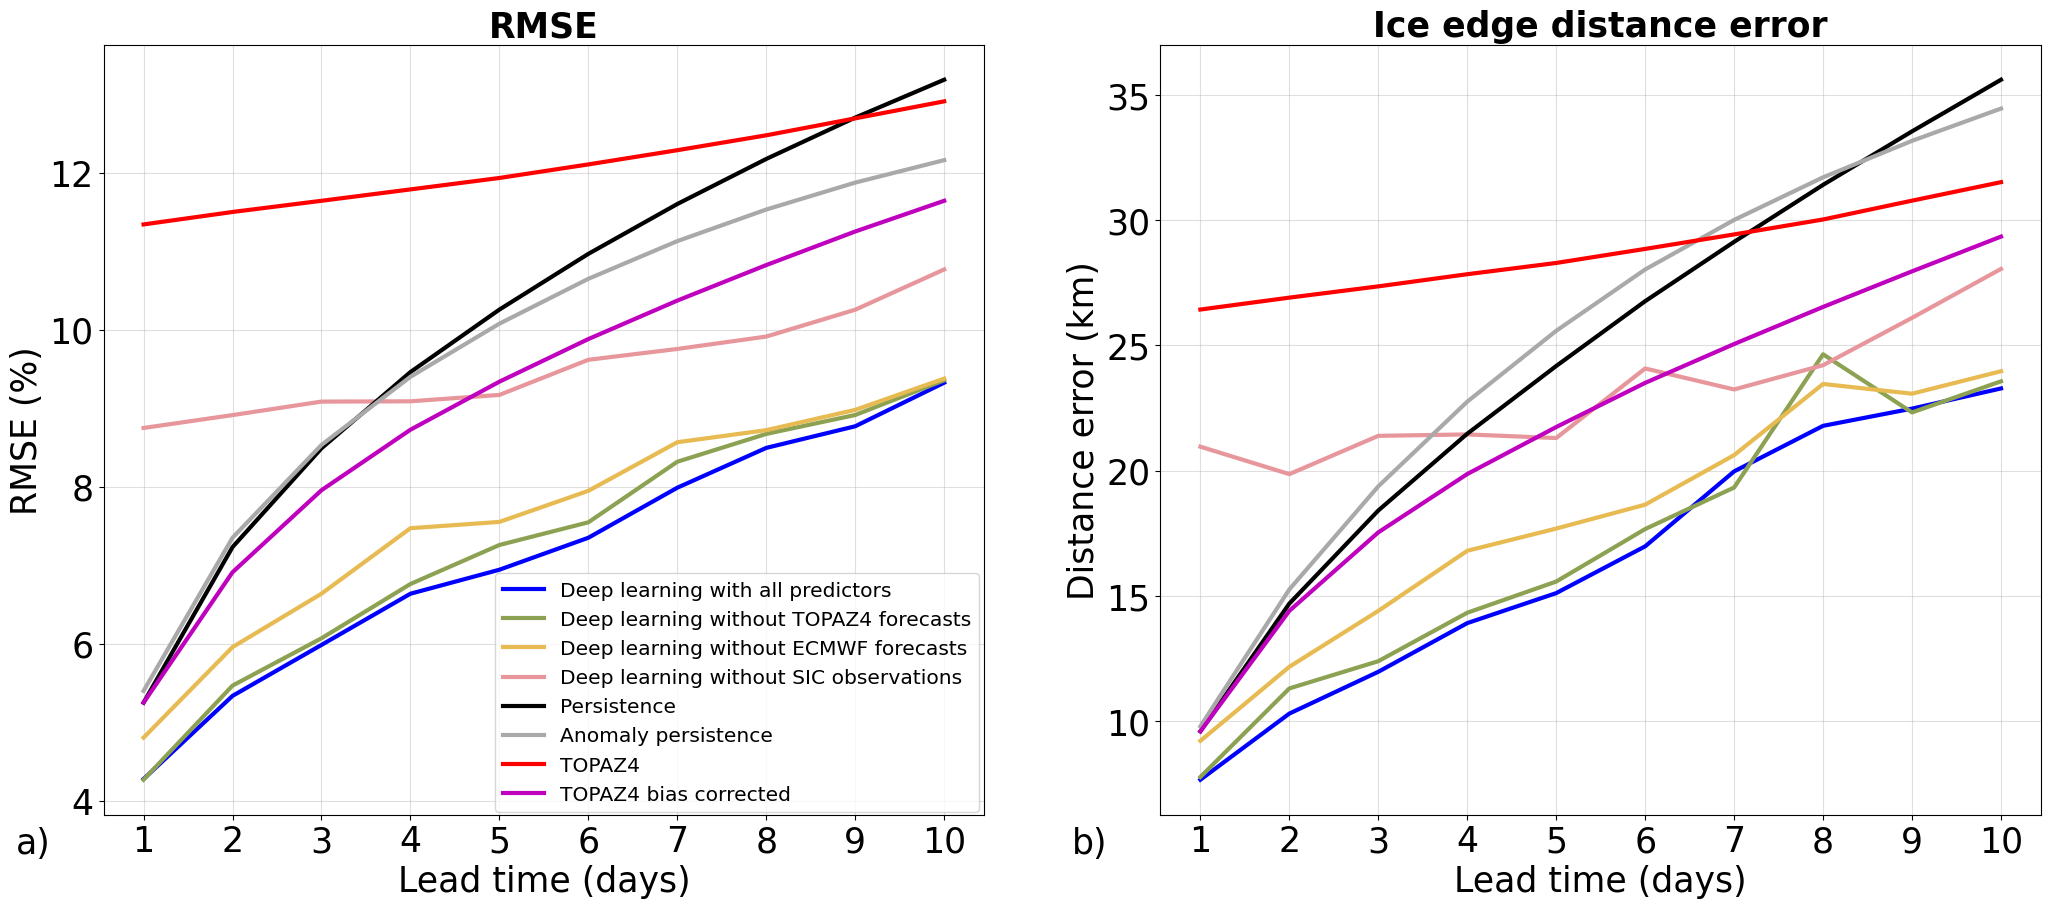

In [123]:
Scores = read_dataset(experiment_names, period, lead_times)
make_figure_absolute(Scores, experiment_names, lead_times, sizefont, sizefont_legend, saving = True)
#
Wilcoxon = {}
Pvalues = {}
Wilcoxon["ref_vs_without_TOPAZ"], Pvalues["ref_vs_without_TOPAZ"] = calculate_wilcoxon("SIC_Attention_Res_UNet", "SIC_Attention_Res_UNet_without_TOPAZ", period, lead_times, metrics = ["RMSE", "IIEElength_15"])
Wilcoxon["ref_vs_without_ECMWF"], Pvalues["ref_vs_without_ECMWF"] = calculate_wilcoxon("SIC_Attention_Res_UNet", "SIC_Attention_Res_UNet_without_ECMWF", period, lead_times, metrics = ["RMSE", "IIEElength_15"])
Wilcoxon["ref_vs_without_obs"], Pvalues["ref_vs_without_obs"] = calculate_wilcoxon("SIC_Attention_Res_UNet", "SIC_Attention_Res_UNet_without_any_obs", period, lead_times, metrics = ["RMSE", "IIEElength_15"])
Wilcoxon["without_TOPAZ_vs_without_ECMWF"], Pvalues["without_TOPAZ_vs_without_ECMWF"] = calculate_wilcoxon("SIC_Attention_Res_UNet_without_TOPAZ", "SIC_Attention_Res_UNet_without_ECMWF", period, lead_times, metrics = ["RMSE", "IIEElength_15"])
#
ratio_RMSE_without_TOPAZ = Scores["SIC_Attention_Res_UNet_without_TOPAZ_RMSE_ML"] / Scores["SIC_Attention_Res_UNet_RMSE_ML"]
ratio_RMSE_without_ECMWF = Scores["SIC_Attention_Res_UNet_without_ECMWF_RMSE_ML"] / Scores["SIC_Attention_Res_UNet_RMSE_ML"]
ratio_IIEElength15_without_TOPAZ = Scores["SIC_Attention_Res_UNet_without_TOPAZ_IIEElength_15_ML"] / Scores["SIC_Attention_Res_UNet_IIEElength_15_ML"]
ratio_IIEElength15_without_ECMWF = Scores["SIC_Attention_Res_UNet_without_ECMWF_IIEElength_15_ML"] / Scores["SIC_Attention_Res_UNet_IIEElength_15_ML"]
print("RMSE without TOPAZ:", np.mean(ratio_RMSE_without_TOPAZ), np.min(ratio_RMSE_without_TOPAZ), np.max(ratio_RMSE_without_TOPAZ))
print("RMSE without ECMWF:", np.mean(ratio_RMSE_without_ECMWF), np.min(ratio_RMSE_without_ECMWF), np.max(ratio_RMSE_without_ECMWF))
print("IIEElength without TOPAZ:", np.mean(ratio_IIEElength15_without_TOPAZ), np.min(ratio_IIEElength15_without_TOPAZ), np.max(ratio_IIEElength15_without_TOPAZ))
print("IIEElength without ECMWF:", np.mean(ratio_IIEElength15_without_ECMWF), np.min(ratio_IIEElength15_without_ECMWF), np.max(ratio_IIEElength15_without_ECMWF))
#
for exp in Pvalues:
    for met in ["RMSE", "IIEElength_15"]:
        for lt in lead_times:
            p_val = Pvalues[exp][met][lt]
            if p_val >= 0.05:
                print("P value not significant", exp, met, "lead time:", lt + 1, "days / P value: ", p_val)